In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
# plt.style.use('rose-pine-dawn')

from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
#     parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_2545/4059766329.py:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


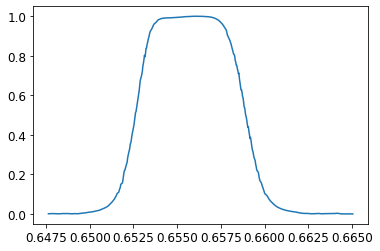

1/2FWHM:0.00316


In [3]:
hafilter = pd.read_csv('Ha_VisAO_filtercurve.dat', comment='#', names=['lam','trans'], delim_whitespace=True)
x, y = hafilter['lam'].to_numpy(), hafilter['trans'].to_numpy()
plt.plot(x, y)
plt.show()

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

hmx = half_max_x(x,y)

# print the answer
fwhm = hmx[1] - hmx[0]
fwhm = fwhm/2
print("1/2FWHM:{:.5f}".format(fwhm))

In [121]:
data = pd.read_csv('HD142527A_ATV.csv')
data = data[data.index != 2]
data = data[data.index != 6]
data[np.isnan(data)==True] = 0
data['Star ratio'] = data['Line Counts']/data['Cont Counts']
data = data[0:6]
data

,Epoch,Line Counts,Cont Counts,Scale,Exposure (sec),Line Ghost Counts,Cont Ghost Counts,"Line BKA (scaled to input psf, so this is already in ""ghost"" units)",Line BKA err,Companion Cont Alpha,Cont Alpha err,log_evidence,ha_SNR,cont_SNR,SDI_SNR,Star ratio
0,56393,282080.0,3.267880e+05,0.98,2.27,1554.5,1719.59,47.54,1.54,23.64,1.46,0.0,11.330000,3.410000,12.32,0.863190
1,56755,568561.0,5.064620e+05,1.19,2.27,2995.0,2507.01,46.81,5.02,24.91,6.95,0.0,8.000000,3.210000,5.96,1.122613
3,57157,488362.0,4.290620e+05,1.16,2.27,2628.0,2161.73,36.50,3.13,20.80,2.86,0.0,9.830000,6.930000,17.76,1.138208
4,57158,1027017.0,9.287127e+05,1.18,2.27,5773.0,4730.93,40.47,5.70,21.23,5.38,0.0,6.410686,2.271677,7.48,1.105850
5,57160,16683996.0,1.013874e+07,1.22,30.00,93783.0,51647.50,42.65,2.51,23.85,5.62,0.0,7.900000,5.980000,7.09,1.645568
7,58235,969732.9,8.096610e+05,1.22,5.00,5451.0,4124.40,38.74,9.01,22.78,8.43,0.0,2.530000,1.500000,6.96,1.197702


In [122]:
from astropy.time import Time
data['year'] = Time(data['Epoch'], format='mjd').decimalyear

In [123]:
print(np.median(data['Line Counts']/data['Line Ghost Counts']))
print(np.median(data['Cont Counts']/data['Cont Ghost Counts']))

print(np.std(data['Line Counts']/data['Line Ghost Counts']))
print(np.std(data['Cont Counts']/data['Cont Ghost Counts']))

179.6801642911621
196.3082900085184
4.593057859955486
3.5638148239561485


In [124]:
# from ghostInvestigation notebook:

cont_g_t_s_count = 112.11593855724848
cont_g_t_s_err_count = 7.771583920200947

cont_g_t_s_peak = 191.27444275928656
cont_g_t_s_err_peak = 25.401211122349526

# not sure which one to choose need to think harder
cont_g_t_s = cont_g_t_s_peak
cont_g_t_s_err = cont_g_t_s_err_peak

# same for line data

ha_g_t_s_count = 102.77872529816074
ha_g_t_s_err_count = 6.4378018336882725
ha_g_t_s_peak = 180.71449513119967
ha_g_t_s_err_peak = 21.602898212349565

ha_g_t_s = ha_g_t_s_peak
ha_g_t_s_err = ha_g_t_s_err_peak


In [125]:
x = data['year']

# alpha * initial guess / ghost-to-star-ratio = contrast

pflux_ha = data['Line BKA (scaled to input psf, so this is already in "ghost" units)']*1e-2/data['Star ratio']
pflux_cont = data['Companion Cont Alpha']*1e-2
contrast_ha = pflux_ha/ha_g_t_s
contrast_cont = pflux_cont/cont_g_t_s

# ERROR PROPAG TIME
pflux_ha_err = data['Line BKA err']*1e-2/data['Scale']
contrast_ha_err = np.sqrt(((pflux_ha_err/pflux_ha)**2)+((ha_g_t_s_err/ha_g_t_s)**2))*contrast_ha
pflux_cont_err = data['Cont Alpha err']*1e-2
contrast_cont_err = np.sqrt(((pflux_cont_err/pflux_cont)**2)+((cont_g_t_s_err/cont_g_t_s)**2))*contrast_cont

In [126]:
import dufte

# global setting:
# plt.style.use(dufte.style)

# with a context manager:
with plt.style.context(dufte.style_bar):
    # ...
    pass

/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_2545/1955654887.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])


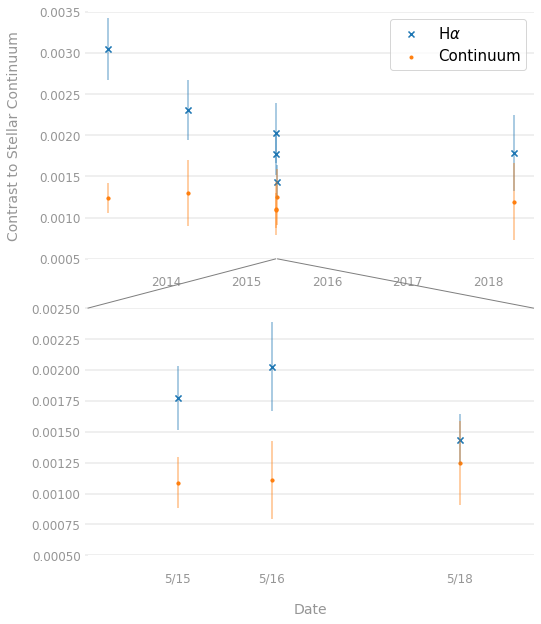

In [205]:
with plt.style.context(dufte.style_bar):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,10))
    ax1.errorbar(x, contrast_ha, yerr=contrast_ha_err, ls='none', marker='x', alpha=0.5)
    ax1.scatter(x, contrast_ha, marker='x', label=r'H$\alpha$')
    ax1.errorbar(x, contrast_cont, yerr=contrast_cont_err, ls='none', marker='.', alpha=0.5)
    ax1.scatter(x, contrast_cont, marker='.', label=r'Continuum')
    
    ax1.set_ylim(0.0005, 0.0035)
#     ax1.set_title('Episodic accretion in the lightcurve of HD 142527B')
    plt.xlabel('Date')
    ax1.set_ylabel('Contrast to Stellar Continuum')
#     ax2.set_ylabel('Contrast to Stellar Continuum')

    ax2.errorbar(x, contrast_ha, yerr=contrast_ha_err, ls='none', marker='x', alpha=0.5)
    ax2.scatter(x, contrast_ha, marker='x')
    ax2.errorbar(x, contrast_cont, yerr=contrast_cont_err, ls='none', marker='.', alpha=0.5)
    ax2.set_ylim(0.0005,0.0025)
    ax2.scatter(x, contrast_cont, marker='.')
    ax2.set_xlim(2015.3645, 2015.3775)
    ax2.set(xticklabels=['5/15','5/16','5/18'], xticks=[2015.367123, 2015.369863, 2015.375342])

    mark_inset(ax1, ax2, loc1a=1, loc1b=4, loc2a=2, loc2b=3, fc="none", ec="0.5", zorder=0)
    
    ax1.legend(loc='upper right', borderaxespad=0.5,    # Small spacing around legend box
               prop={'size': 15}, labelcolor='k'
#                title=r"Instrument / $\lambda$ / Author"  # Title for the legend
               )

    # mark_inset(ax1,ax2,loc1=1,loc2=2,fc="none",ec='0.5')
    plt.savefig('hd142527B_contrast_lc.png', dpi=300)

In [128]:
# Close et al 2014

C14epoch = Time(56393, format='mjd').decimalyear
C14_hamag = 6.33
C14_hamag_err = 0.20
C14_contmag = 7.5
C14_contmag_err = 0.25

# Cugno et al 2019
import datetime 
Cu19yr = datetime.datetime(2016,3,31)
Cu19epoch = Time(Cu19yr, format='datetime').decimalyear
Cu19_hamag = 6.7
Cu19_hamag_err = 0.2
Cu19_contmag = 7.3
Cu19_contmag_err = 0.3


In [129]:
# SAME BUT IN MAG

mag_ha = -2.5*np.log10(contrast_ha)
mag_cont = -2.5*np.log10(contrast_cont)

# ERROR PROPAG TIME

mag_ha_err = 2.5*0.434*(contrast_ha_err/contrast_ha)
mag_cont_err = 2.5*0.434*(contrast_cont_err/contrast_cont)

In [199]:
mag_ha

0    6.290100
1    6.592211
3    6.877305
4    6.733890
5    7.108475
7    6.867956
dtype: float64

In [201]:
mag_ha[0]-mag_ha[1]

-0.30211135581254034

In [196]:
contrasts = pd.DataFrame()
contrasts['yr'] = x
contrasts['DmagHa'] = contrast_ha
contrasts['DmagCont'] = contrast_cont
contrasts.to_csv('HD142527B_contrasts.csv')
contrasts2 = pd.DataFrame()
contrasts2['DmagHa'] = mag_ha
contrasts2['dmHaE'] = mag_ha_err
contrasts2['DmagCont'] = mag_cont
contrasts2['dmContE'] = mag_cont_err
contrasts2.to_clipboard()

In [194]:
contmed = np.median(mag_cont)
condstdev = np.std(mag_cont)

hamed = np.median(mag_ha)
hastdev = np.std(mag_ha)

print(hamed, hastdev)

print(contmed, condstdev)

6.800922923643521 0.25662499102976394
7.290140873573949 0.06963972725338666


In [216]:
mag_ha_err

0    0.133346
1    0.169917
3    0.158611
4    0.193218
5    0.155694
7    0.279633
dtype: float64

In [218]:
np.median(mag_ha_err)/np.median(mag_ha)

0.024153225122864212

/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_2545/797431286.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set(xticklabels=['5/15/15','5/16/15','5/18/15'], xticks=[2015.367123, 2015.369863, 2015.375342])


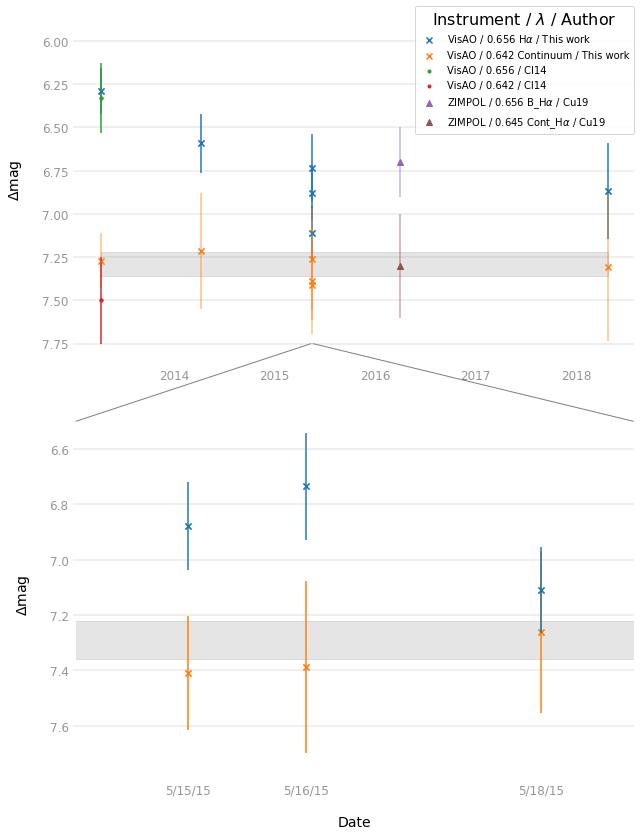

In [217]:
with plt.style.context(dufte.style_bar):
    import matplotlib as mpl
    mpl.rcParams['text.color'] = 'black'
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,14))
    plt.rc('legend', fontsize=12)
    plt.rc('figure', titlesize=12) 

    # plot my mags
    # fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.errorbar(x, mag_ha, yerr=mag_ha_err, ls='none', marker='x')#, alpha=0.5)
    ax1.scatter(x, mag_ha, marker='x', label=r'VisAO / 0.656 H$\alpha$ / This work')
    ax1.errorbar(x, mag_cont, yerr=mag_cont_err, ls='none', marker='x', alpha=0.5)
    ax1.scatter(x, mag_cont, marker='x', label=r'VisAO / 0.642 Continuum / This work')
#     secax = ax1.secondary_yaxis('right', functions=(ha2acc, acc2ha))
#     secax.set_xlabel('accretion')
    ax1.fill_between(x, contmed-condstdev, contmed+condstdev, color='k', alpha=0.1, zorder=0)
    ax1.set_ylim(7.8,5.8)
#     ax1.set_title(r'The H$\alpha$ lightcurve of HD 142527B')
    # plot median and stdev of continuum as fill between
    ax2.set_xlabel('Date')
    ax1.set_ylabel(r'$\Delta$mag')
    ax2.set_ylabel(r'$\Delta$mag')

    # plot close 2014
    ax1.scatter(C14epoch, C14_hamag, marker='.', label=r'VisAO / 0.656 / Cl14')
    ax1.errorbar(C14epoch, C14_hamag, yerr=C14_hamag_err, ls='none', marker='.')#, alpha=0.5)
    ax1.scatter(C14epoch, C14_contmag, marker='.', label='VisAO / 0.642 / Cl14')
    ax1.errorbar(C14epoch, C14_contmag, yerr=C14_contmag_err, ls='none', marker='.')#, alpha=0.5)
    # plot NIR variability observed by Claudi 2019
#     ax1.fill_between(x, contmed-0.25, contmed+0.25, alpha=0.1)
    # plot cugno 2019
    ax1.scatter(Cu19epoch, Cu19_hamag, marker='^', label=r'ZIMPOL / 0.656 B_H$\alpha$ / Cu19')
    ax1.errorbar(Cu19epoch, Cu19_hamag, yerr=Cu19_hamag_err, ls='none', marker='^', alpha=0.5)
    ax1.scatter(Cu19epoch, Cu19_contmag, marker='^', label=r'ZIMPOL / 0.645 Cont_H$\alpha$ / Cu19')
    ax1.errorbar(Cu19epoch, Cu19_contmag, yerr=Cu19_contmag_err, ls='none', marker='^', alpha=0.5)
    # zoom in on May 2015
    ax2.errorbar(x, mag_ha, yerr=mag_ha_err, ls='none', marker='x', zorder=10)#, alpha=0.5)
    ax2.scatter(x, mag_ha, marker='x', zorder=10)
    ax2.errorbar(x, mag_cont, yerr=mag_cont_err, ls='none', marker='x')#, alpha=0.5)
    ax2.scatter(x, mag_cont, marker='x')
    ax2.fill_between(x, contmed-condstdev, contmed+condstdev, color='k', alpha=0.1, zorder=0)
#     ax2.fill_between(x, contmed-0.25, contmed+0.25, alpha=0.1)
    ax2.set_ylim(7.75,6.5)
    ax2.set_xlim(2015.3645, 2015.3775)
    ax2.set(xticklabels=['5/15/15','5/16/15','5/18/15'], xticks=[2015.367123, 2015.369863, 2015.375342])
    mark_inset(ax1, ax2, loc1a=1, loc1b=1, loc2a=2, loc2b=2, fc="none", ec="0.5", zorder=0)



#     fig.subplots_adjust(bottom=0.22, wspace=0.33)

    ax1.legend(loc='upper right', borderaxespad=0.0,    # Small spacing around legend box
               prop={'size': 10}, labelcolor='k',
               title=r"Instrument / $\lambda$ / Author"  # Title for the legend
               )

    # ax[1].legend(handles = [l1,l2,l3] , labels=['A', 'B', 'C'],loc='upper center', 
    #              bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3)

    ax1.xaxis.label.set_color('black')
    ax2.xaxis.label.set_color('black')
    
    ax1.yaxis.label.set_color('black')
    ax2.yaxis.label.set_color('black')
    
#     ax1.legend.title.set_color('black')
    
    plt.savefig('hd142527B_contrast_lc_mag.png', dpi=300)

In [12]:
contrasts

,yr,DmagHa,DmagCont
0,2013.273973,0.003048,0.001236
1,2014.265753,0.002307,0.001302
3,2015.367123,0.001775,0.001087
4,2015.369863,0.002025,0.001110
5,2015.375342,0.001434,0.001247
7,2018.317808,0.001790,0.001191


In [195]:
contrasts.to_clipboard()